# Laboratorio di Simulazione Numerica: lezione 4

Elia Steve (47122A)

In [2]:
import sys
sys.path.append("/Users/elia/LaboratorioDiSimulazioneNumerica")
from lib_NSL_py.simulator import run_simulation, set_properties, set_config_file

In [3]:
import numpy as np
import subprocess
import os
from matplotlib import pyplot as plt

In [4]:
#Path of the NSL_SIMULATOR folder. Assumes the notebook is run within LSN_04
nsl_sim_path = "../NSL_SIMULATOR"

# Esercizi 4.1, 4.2

In questi esercizi dobbiamo estendere il codice in `NSL_SIMULATOR` aggiungendo il calcolo della pressione per simulazioni di dinamica molecolare, tramite la relazione (valida per sistemi di Lennard-Jones)
$$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle, $$
e usare il codice per simulare un sistema di Argon in fase solida, liquida e gassosa.

Oltra all'aggiunta del calcolo della pressione, ho effettuato altre modifiche al codice:
* ho aggiunto la possibilità di eseguire delle iterazioni di equilibrazione prima dell'inizio delle misure. Per controllare questa possibilità ho creato un nuovo parametro da aggiungere al file `input.dat`.
* Nel codice la misura di alcune proprietà dipende dal fatto che se ne stiano misurando delle altre: per esempio la misura della temperatura dipende da quella dell'energia cinetica, e quella della pressione da quella della temperatura. Quando si prova a misurare una proprietà senza misurare anche una delle sue dipendenze, il comportamento del codice non è definito, e ho aggiunto un controllo che segnali quando questo succede.

Inoltre, ho scritto delle funzioni (in `lib_NSL_py/simulator.py`) che permettono di controllare il simulatore all'interno di uno script Python (e quindi di questo notebook).

La necessità di eseguire delle iterazioni di equilibrazione nel caso della dinamica molecolare sorge per la ragione seguente. All'inizio della simulazione, il sistema viene inizializzato in una certa posizione (a cui corrisponde un'energia potenziale) e con velocità (e quindi energie cinetiche) tali che la temperatura sia quella impostata nella configurazione iniziale: questo dunque corrisponde a fissare l'energia totale. Nel corso dei primi passi della simulazione, le particelle passano alle configurazioni tipiche per i parametri del sistema, che hanno energia potenziale diversa da quella iniziale: siccome la simulazione è eseguita con l'algoritmo di Verlet, che conserva l'energia totale, a questa variazione di energia potenziale corrisponde una variazione di energia cinetica, e quindi di temperatura. La temperatura della simulazione dopo questa fase di equilibrazione è quindi diversa da quella impostata nel file di input (è più bassa nel caso del solido e liquido e più alta nel caso del gas): questo vuol dire che per eseguire una simulazione a una temperatura fissata la temperatura di input deve essere un'altra. Per trovare questa temperatura ho definito la funzione seguente, che esegue delle simulazioni, controlla la temperatura finale e aggiusta quella iniziale per provare ad ottenere la temperatura che desideriamo.

In [27]:
def fix_temperature(folder, expected_temp, density, r_cut):
    temperature = expected_temp
    for i in range(10):
        print("Running with initial temp", temperature)
        run_simulation(folder=folder, temperature=temperature, density=density, r_cut=r_cut, n_steps=100, n_blocks=100, n_eqsteps=1000)
        with open(folder + "/OUTPUT/temperature.dat", "r") as f:
            f.readline() #Title line
            for line in f:
                __,  __, t, err = map(float, line.strip().split())
            print("Final temp is", t, "±", err)
            delta_t = t - expected_temp
            if (abs(delta_t) > err):
                #This rule was found heuristically
                temperature -= delta_t
                print("Final temperature is not what we wanted... Trying again")
            else:
                return temperature

Ora eseguiamo le simulazioni. Definisco una lista di dizionari con i parametri per le varie fasi, e scrivo la configurazione iniziale appropriata per il sistema di Lennard-Jones:

In [8]:
starting_parameters = [ # T, rho, r_cut 
    {"T":0.8, "rho":1.1, "r_cut":2.2, "name":"solid", "it_name":"Solido"},
    {"T":1.1, "rho":0.8, "r_cut":2.5, "name":"liquid", "it_name":"Liquido"},
    {"T":1.2, "rho":0.05, "r_cut":5.0, "name":"gas", "it_name":"Gas"}
]

In [7]:
set_config_file(nsl_sim_path, "lj")

Determino la temperatura iniziale nei vari casi:

In [29]:
for parameters in starting_parameters:
    try:
        with open("initial_temp_" + str(parameters["T"]) + ".dat") as f:
            parameters["starting_T"] = float(f.readline().strip())
            print("For the simulation with T =", parameters["T"], "start at", parameters["starting_T"])
    except FileNotFoundError:
        parameters["starting_T"] = fix_temperature(
            nsl_sim_path,
            expected_temp=parameters["T"],
            density=parameters["rho"],
            r_cut=parameters["r_cut"]
        )
        with open("initial_temp_" + str(parameters["T"]) + ".dat", "w") as f:
            f.write(str(parameters["starting_T"]))

Running with initial temp 0.8
Final temp is 0.4094813 ± 0.001724512
Final temperature is not what we wanted... Trying again
Running with initial temp 1.1905187000000002
Final temp is 0.6150638 ± 0.002403899
Final temperature is not what we wanted... Trying again
Running with initial temp 1.3754549000000003
Final temp is 0.712408 ± 0.003096724
Final temperature is not what we wanted... Trying again
Running with initial temp 1.4630469000000002
Final temp is 0.7577886 ± 0.003558247
Final temperature is not what we wanted... Trying again
Running with initial temp 1.5052583000000002
Final temp is 0.7818663 ± 0.003214613
Final temperature is not what we wanted... Trying again
Running with initial temp 1.5233920000000003
Final temp is 0.7910561 ± 0.003538802
Final temperature is not what we wanted... Trying again
Running with initial temp 1.5323359000000003
Final temp is 0.7963928 ± 0.003478417
Final temperature is not what we wanted... Trying again
Running with initial temp 1.535943100000000

Imposto le proprietà da misurare ed eseguo la simulazione:

In [30]:
properties = [
    "total_energy",
    "potential_energy",
    "kinetic_energy",
    "temperature",
    "pressure"
]
set_properties(nsl_sim_path, properties)

In [31]:
for parameters in starting_parameters:
    if not os.path.isdir(parameters["name"]):
        run_simulation(
            folder = nsl_sim_path,
            temperature = parameters["starting_T"],
            density = parameters["rho"],
            r_cut = parameters["r_cut"],
            n_steps = 300,
            n_blocks = 100,
            n_eqsteps = 5000
        )
        subprocess.run(
            [
                "rsync",
                "-a",
                "--delete",
                nsl_sim_path + "/OUTPUT/",
                parameters["name"] + "/"
            ]
        )

Faccio il grafico dei risultati:

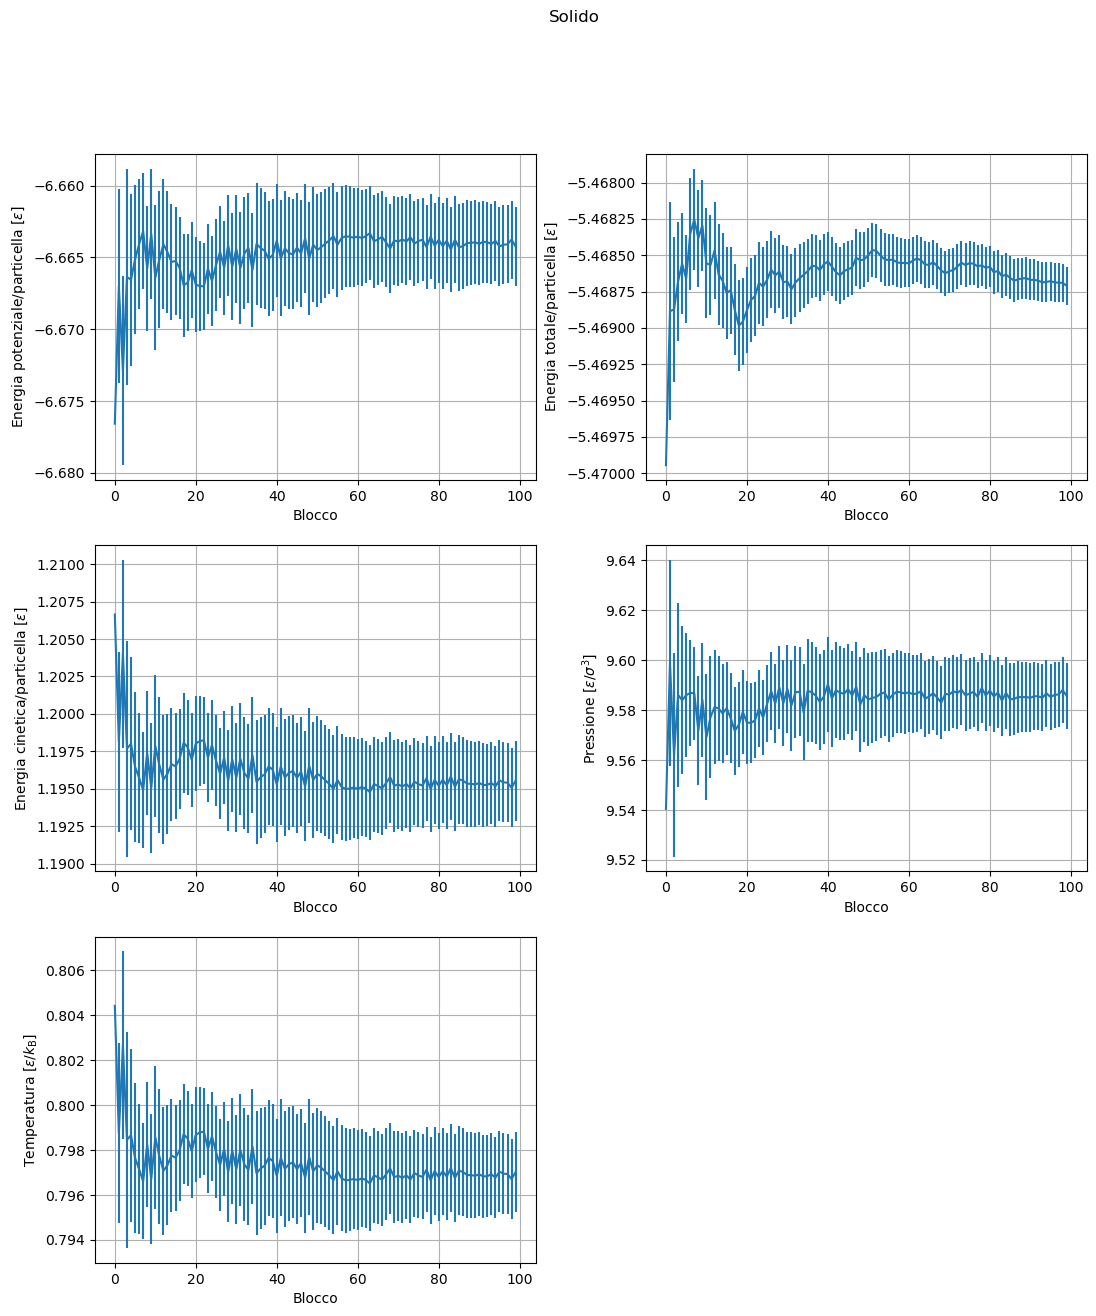

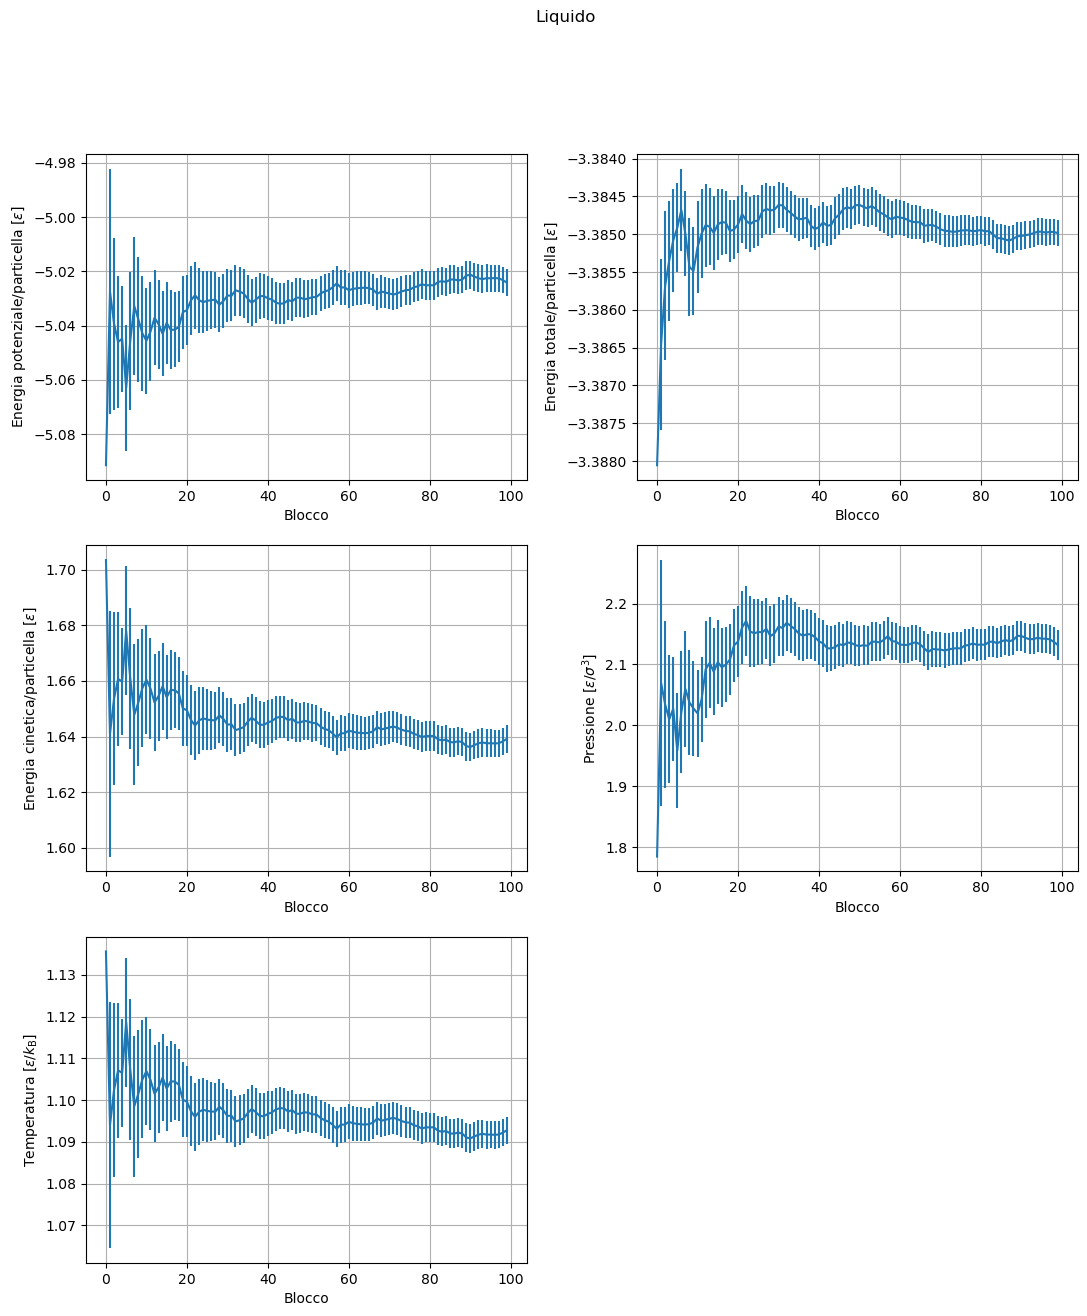

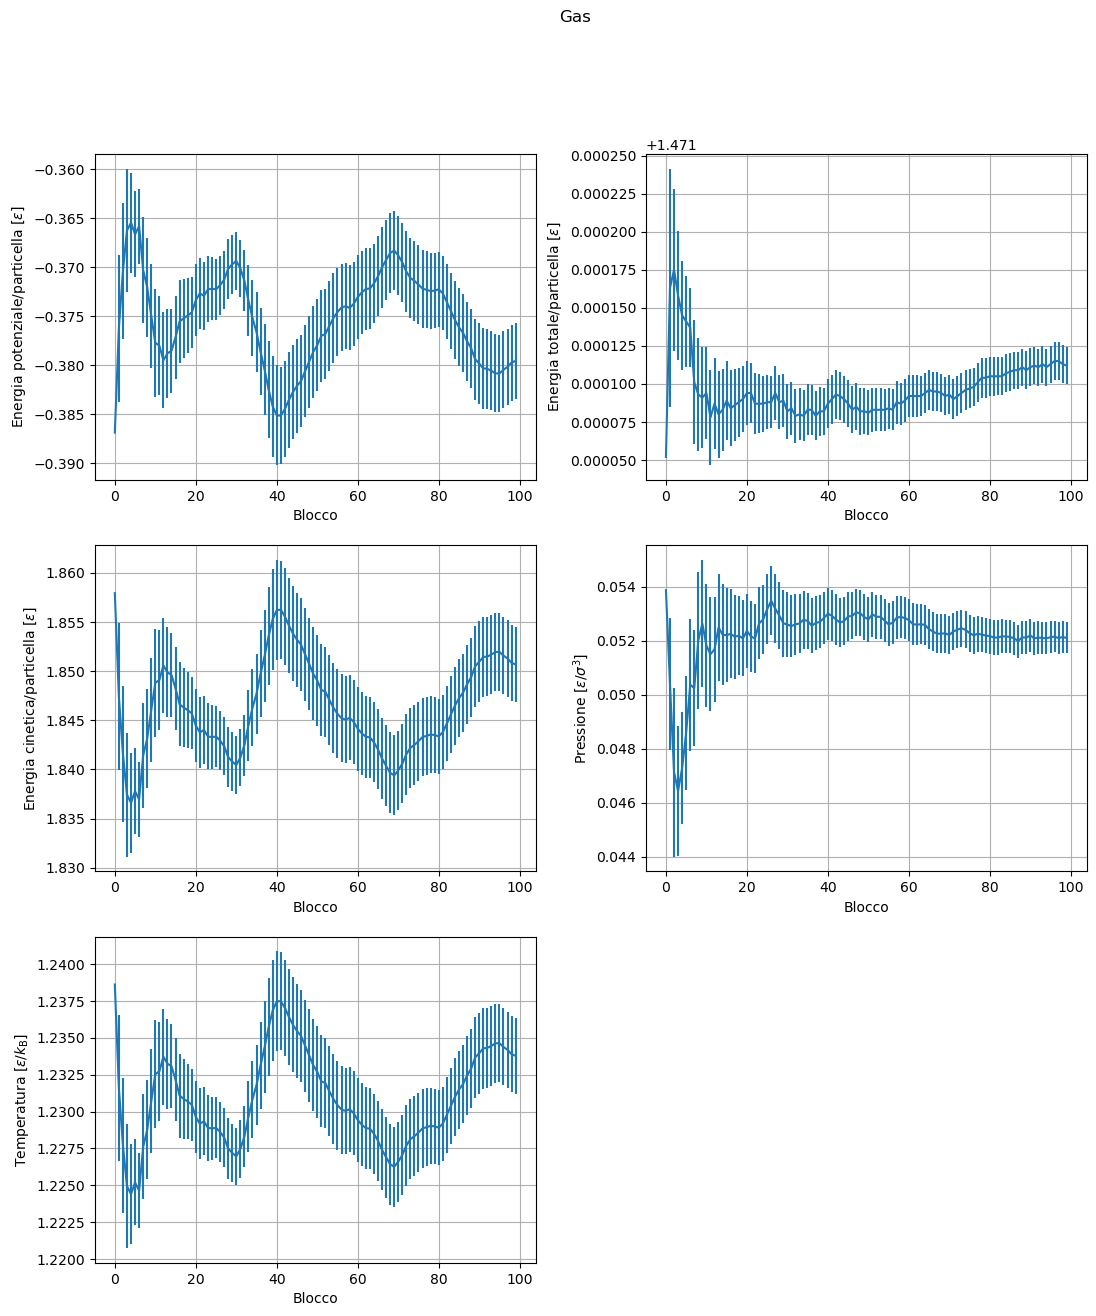

In [32]:
properties_plot = [
    ("Energia potenziale/particella", "potential_energy.dat", r"$[\epsilon]$"),
    ("Energia totale/particella", "total_energy.dat", r"$[\epsilon]$"),
    ("Energia cinetica/particella", "kinetic_energy.dat", r"$[\epsilon]$"),
    ("Pressione", "pressure.dat", r"$[\epsilon/\sigma^3]$"),
    ("Temperatura", "temperature.dat", r"$[\epsilon/k_\mathrm{B}]$")
]

for parameters in starting_parameters:
    fig, axx = plt.subplots(3, 2, figsize=(12.8, 14.4), gridspec_kw = {"wspace":0.25})
    fig.delaxes(axx[2][1])
    for (property, filename, unit), ax in zip(properties_plot, axx.flatten()):
        fullname = parameters["name"] + "/" + filename
        aves = np.loadtxt(fullname, usecols=2)
        errs = np.loadtxt(fullname, usecols=3)
        xs = np.arange(len(aves))
        #plt.subplots(figsize=(12, 6))
        ax.errorbar(xs, aves, yerr=errs)
        ax.set_xlabel("Blocco")
        ax.set_ylabel(property + " " + unit)
        ax.grid()
    fig.suptitle(parameters["it_name"])
    plt.show()

Dai grafici dei risultati osserviamo che:

* la pressione decresce passando da solido a liquido e da liquido a gas, con il decrescere della densità e il crescere della temperatura.
* I grafici di temperatura ed energia cinetica sono praticamente identici, visto che queste due quantità sono proporzionali; inoltre i grafici di energia cinetica e potenziale sono praticmente uno la riflessione dell'altro, visto che la loro somma è una quantità conservata.
* Si nota una forte variabilità nei grafici di energia cinetica e potenziale nel caso del gas.